### v We proceed to define a layer which can perform post-process operations on a partial convolution output

One layer is replaced with two compression layers. Both comp layers can be convolutional computations.


$$W^{C_1 \times C_2 \times D_1 \times D_2} \Rightarrow M^{C_1 \times C_2 \times D_1 \times R} \times N^{1 \times 1 \times R \times D_2}$$

where $ R \lt \lt D_1,D_2 $

We expect to reduce the number of weights in the network:

$$S = \sum_{l \in layers} \frac{C_1 \times C_2 \times D_1 \times R + 1 \times 1 \times R \times D_2}{ C_1 \times C_2 \times D_1 \times D_2}$$

$S$ would be about $0.5$ where $R/D_2 = 0.5$. Computation speed may increase proportionally or non-proportionally to $S$ since different layers apply their kernel matrix differently to vary

In [1]:
import os, sys

sys.path.append('../Pose_Estimation')

from config_reader import config_reader
config_reader()
param_, model_ = config_reader()

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
import tensorflow as tf
from keras import backend as K

# Common deps
import numpy as np
import cv2
import util
print 'LOADED MODULES'
import numpy.linalg as LA

session = tf.Session()

Using TensorFlow backend.


LOADED MODULES


In [2]:

def relu(x):
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):

    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")

    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)
    x = pooling(x, 2, 2, "pool3_1")

    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)

    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)

    return x

def stage1_block(x, num_p, branch):

    # Block 1
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)

    return x

def stageT_block(x, num_p, stage, branch, prefix='Heatmap'):

    # Block 1
    with tf.name_scope('%sBlock' % (prefix)):
        x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))

        return x

In [3]:
def create_model(vgg=vgg_block):
    input_shape = (None,None,3)
    img_input = Input(shape=input_shape)

    stages = 6
    np_branch1 = 38
    np_branch2 = 19

    # VGG
    with tf.name_scope('VggConvLayer'):
        stage0_out = vgg(img_input)

    # stage 1
    with tf.name_scope('DualLayer%d' % (1)):
        stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
        stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
        x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

    # stage t >= 2
    for sn in range(2, stages + 1):
        with tf.name_scope('DualLayer%d' % (sn)):
            stageT_branch1_out = stageT_block(x, np_branch1, sn, 1, prefix='Heat')
            stageT_branch2_out = stageT_block(x, np_branch2, sn, 2, prefix='PAF')
            if (sn < stages):
                x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])
    return Model(img_input, [stageT_branch1_out, stageT_branch2_out])



In [158]:
model = create_model()
model.load_weights('../Pose_Estimation/model/keras/model.h5')

In [5]:
raw_heatmap = tf.placeholder(tf.float32, shape=(None, None, None, 19))
raw_paf = tf.placeholder(tf.float32, shape=(None, None, None, 38))
resize_size = tf.placeholder(tf.int32, shape=(2))

resize_heatmap = tf.transpose(tf.image.resize_images(raw_heatmap, resize_size, align_corners=True), perm=[0, 3, 1, 2])
resize_paf = tf.transpose(tf.image.resize_images(raw_paf, resize_size, align_corners=True), perm=[0, 3, 1, 2])

test_writer = tf.summary.FileWriter('logs/test', session.graph)

In [169]:
import ast
for i in open(test_vidfile + '.dat').readlines():
    datContent=ast.literal_eval(i)
        
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']

In [170]:
import cv2, time
test_vidfile = '../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4'

frames_saved = []
def process_video(model, proc_func, limit_frames=None, save_frames=False):
    global frames_saved
    if save_frames:
        frames_saved = []
    
    tmin = 1000000000000
    tmax = -1
    tavg = 0
    start_time = time.time()
    print test_vidfile
    video_capture = None
    video_capture = cv2.VideoCapture(test_vidfile)

    results = []
    frame_i = 0
    while True:
    # Capture frame-by-frame
        ret, frame = video_capture.read()
        if frame is None:
            print("end of video capture")
            break
        if frame_i % 10 is 0:
            print 'Frame #:', frame_i
        t0 = time.time()
        pitcher_frame = frame[top_p:bottom_p, left_p:right_p]
        if save_frames:
            frames_saved.append(pitcher_frame)
            print 'Saved', len(frames_saved)
        result = proc_func(model, pitcher_frame)
        results.append(result)
        dt = time.time() - t0
        tavg += dt
        if tmin > dt: tmin = dt
        if tmax < dt: tmax = dt
        #pitcher = frame[top_p:bottom_p, left_p:right_p]
        #batter = frame[top_b:bottom_b, left_b:right_b]
        #df.loc[p]=[int(p),handle_one(pitcher),handle_one(batter) ]

        frame_i += 1
        if limit_frames and frame_i is limit_frames:
            break
    tavg /= float(frame_i)
    print '| AVG: %.2f' % (tavg)
    print '| MIN: %.2f' % (tmin)
    print '| MAX: %.2f' % (tmax)
    print '| TOT: %.2f' % (time.time() - start_time)
    return results
#     return (tavg, tmin, tmax)

In [171]:
def evaluate(in_model, oriImg, scale=1.0):
    print 'scale', scale
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2))/256 - 0.5;

    output1, output2 = in_model.predict(input_img)

    # Replicating bilinear upsampling to heatmaps procedure.
    resize_dict = {
        resize_size: [oriImg.shape[0], oriImg.shape[1]],
        raw_heatmap: output2,
        raw_paf: output1,
    }

    heatmap, paf = session.run([resize_heatmap, resize_paf], feed_dict=resize_dict)
    heatmap, paf = heatmap[0], paf[0]

    return (output1, output2), (heatmap, paf)

def handle_one_simple(in_model, oriImg):
    multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

    scale = model_['boxsize'] / float(oriImg.shape[0])

    e=1
    b=0
    len_mul=e-b
    multiplier=multiplier[b:e]
    # heatmap_avg = TORCH_CUDA(torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])))
    # paf_avg = TORCH_CUDA(torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])))
    
    results = []
    for m in range(1): #len(multiplier)):
        scale = multiplier[m]

        (output1, output2), (heatmap, paf) = evaluate(in_model, oriImg, scale=scale)
        results.append((heatmap, paf))

    return results
        #globals()['heatmap_avg_%s'%m] = heatmap
        #globals()['paf_avg_%s'%m] = paf

In [172]:
def eval_model(in_model, frame):
    return handle_one_simple(in_model, frame)

res = process_video(model, eval_model, limit_frames=3)
print len(res), type(res[0])

import numpy.linalg as LA
def score_heatmaps(a, b):
    return LA.norm(np.array(a) - np.array(b))

print score_heatmaps(res[0][0][1][0], res[0][0][1][0])

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
scale 0.828828828829
scale 0.828828828829
scale 0.828828828829
| AVG: 0.14
| MIN: 0.13
| MAX: 0.15
| TOT: 0.54
3 <type 'list'>
0.0


In [10]:
bad_arr = np.copy(res[0][0][1][0])
bad_arr[0][0] = 100

score_heatmaps(res[0][0][1][0], bad_arr)

100.01266

In [11]:
print model.layers[167].get_weights()[0].shape
print model.layers[167].get_weights()[1]

(7, 7, 128, 128)
[ 0.33225948  0.16188022  0.27922881  0.01869457  0.2429717   0.04713162
  0.04273088  0.03856203  0.08375378  0.22445051 -0.03753312  0.28361431
  0.43102345  0.08991333 -0.25694507  0.29533273 -0.54563618  0.19100149
 -0.12199891  0.1655786   0.22925213 -0.02104932  0.13171312  0.1694825
  0.16371267  0.1409096  -0.17146735  0.39046121  0.11737511  0.28404894
  0.07402838 -0.02940818  0.00414771  0.08003046  0.09546474  0.02906054
  0.15117237  0.18039274  0.01010426  0.13829383  0.22488749 -0.39809573
  0.20629252  0.26374558  0.20252872  0.2310368   0.40361959  0.24086778
  0.17147592  0.22884029  0.04008362  0.16657349  0.33752474  0.29427883
  0.30120459  0.2103582   0.0777486   0.24689034  0.08535825  0.2736448
  0.10019904 -0.02264843  0.18083756  0.23046485  0.0244466   0.26060003
  0.04701021  0.11287675  0.43217793  0.12824084  0.10439596  0.04660356
  0.30289069  0.38710156  0.05434372  0.0263001   0.21180336  0.15619536
  0.17551981  0.08537221  0.18048693

In [344]:
def my_vgg_block(x):

    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    
#     print 'Identity Shapes:', ii.input_shape, ii.output_shape
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
#     x = conv(x, 128, 3, "conv2_1")
    x = Conv2D(32, (3, 3), padding='same', name="comp_conv2_1a", use_bias=False)(x)
    x = Conv2D(128, (1, 1), padding='same', name="comp_conv2_1b", use_bias=True)(x)
    x = relu(x)

    #     x = conv(x, 128, 3, "conv2_2")
    x = Conv2D(32, (3, 3), padding='same', name="comp_conv2_2a", use_bias=False)(x)
    x = Conv2D(128, (1, 1), padding='same', name="comp_conv2_2b", use_bias=True)(x)
    
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")

    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)
#     x = conv(x, 256, 3, "conv3_2")
    x = Conv2D(64, (3, 3), padding='same', name="comp_conv3_2a", use_bias=False)(x)
    x = Conv2D(256, (1, 1), padding='same', name="comp_conv3_2b", use_bias=True)(x)
    
    x = relu(x)
#     x = conv(x, 256, 3, "conv3_3")
    x = Conv2D(64, (3, 3), padding='same', name="comp_conv3_3a", use_bias=False)(x)
    x = Conv2D(256, (1, 1), padding='same', name="comp_conv3_3b", use_bias=True)(x)
    x = relu(x)
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)
    x = pooling(x, 2, 2, "pool3_1")

    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)

    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)

    return x#     return new_model

In [345]:
mod_model = create_model(vgg=my_vgg_block)
# mod_model.load_weights('../Pose_Estimation/model/keras/model.h5')
print 'Modified:', len(mod_model.layers)

Modified: 185


In [346]:
def copy_weights(from_model, to_model, overrides={}):
    from_i, to_i = 0, 0

    while from_i < len(from_model.layers):
        if from_i in overrides:
            print 'Overriding:', from_i, to_i
            many_layers = overrides[from_i]
            for ii, weights in enumerate(many_layers):
                print '  - Copying', to_i, len(weights)
                print weights[0][:, :, 0, 0]
                to_model.layers[to_i].set_weights(weights)
                to_i += 1
            from_i += 1
        else:
            original_weights = from_model.layers[from_i].get_weights()
            to_model.layers[to_i].set_weights(original_weights)
            to_i += 1
            from_i += 1
        if from_i % 10 is 0: print 'Progress: (%d/%d)' % (to_i, len(to_model.layers))

def add_mapping(mapping, layer_i, weights):
    mapping[layer_i] = weights

def compress_conv_layer_svd(model, layer_i, keep=None, keep_ratio=None):
    weights, bias = model.layers[layer_i].get_weights()
    wshape = weights.shape
    
    if keep_ratio and keep_ratio > 0 and keep_ratio <= 1.0:
        keep = int(np.floor(wshape[3] * float(keep_ratio)))

    if keep and wshape[3] < keep:
        raise Exception('> Keep rank (%d) exceeds output dimension (%d)' % (keep, wshape[2]))
    if keep: print '| %d-compressing shape:' % (keep), wshape
    else: print '| No compression:', wshape

    # Make a copy before risking modifying the model weights
    weights = np.copy(weights)
    bias = np.copy(bias)
    flat_layer = np.reshape(weights, (wshape[0] * wshape[1] * wshape[2], wshape[3]))

    print flat_layer.shape
        
    U, s, V = LA.svd(flat_layer)
    smat = np.zeros(flat_layer.shape)
    smat[:len(s), :] = np.diag(s)
    
    if keep:
        U, smat, V = U[:, :], smat[:, :keep], V[:keep, :]

    print '| Decomp shapes:', U.shape, smat.shape, V.shape
    
    rebuilt = np.dot(np.dot(U, smat), V)
    loss = LA.norm(rebuilt - flat_layer)
    print '| Compounded Loss: %.1f' % (loss)

    weights1 = np.dot(U, smat)
    weights1 = np.reshape(weights1, (wshape[0], wshape[1], wshape[2], smat.shape[1]))
    
    weights2 = np.copy(V)
    weights2 = np.reshape(weights2, (1, 1, weights2.shape[0], weights2.shape[1]))

    print weights1.shape, weights2.shape, bias.shape
    
    return [weights1], [weights2, bias]

In [347]:
model = create_model()
model.load_weights('../Pose_Estimation/model/keras/model.h5')

mappings = {}
ccl = compress_conv_layer_svd(model, 6, keep=32)
add_mapping(mappings, 6, ccl)

ccl = compress_conv_layer_svd(model, 8, keep=32)
add_mapping(mappings, 8, ccl)

ccl = compress_conv_layer_svd(model, 13, keep=64)
add_mapping(mappings, 13, ccl)

ccl = compress_conv_layer_svd(model, 15, keep=64)
add_mapping(mappings, 15, ccl)

| 32-compressing shape: (3, 3, 64, 128)
(576, 128)
| Decomp shapes: (576, 576) (576, 32) (32, 128)
| Compounded Loss: 8.9
(3, 3, 64, 32) (1, 1, 32, 128) (128,)
| 32-compressing shape: (3, 3, 128, 128)
(1152, 128)
| Decomp shapes: (1152, 1152) (1152, 32) (32, 128)
| Compounded Loss: 13.9
(3, 3, 128, 32) (1, 1, 32, 128) (128,)
| 64-compressing shape: (3, 3, 256, 256)
(2304, 256)
| Decomp shapes: (2304, 2304) (2304, 64) (64, 256)
| Compounded Loss: 17.9
(3, 3, 256, 64) (1, 1, 64, 256) (256,)
| 64-compressing shape: (3, 3, 256, 256)
(2304, 256)
| Decomp shapes: (2304, 2304) (2304, 64) (64, 256)
| Compounded Loss: 15.7
(3, 3, 256, 64) (1, 1, 64, 256) (256,)


In [348]:
# model_compressed_1 = create_model(vgg=my_vgg_block)
copy_weights(model, mod_model, mappings)

print mod_model.layers[6].get_weights()[0][:, :, 0, 0]

Overriding: 6 6
  - Copying 6 1
[[ 0.03848544 -0.06058674 -0.02414476]
 [ 0.02179804 -0.21602203 -0.05026059]
 [ 0.02376109  0.06057026  0.0821798 ]]
  - Copying 7 2
[[ 0.00504957]]
Overriding: 8 9
  - Copying 9 1
[[ 0.05537885  0.036581    0.03775403]
 [ 0.02740394 -0.00586265 -0.00570563]
 [ 0.00946126 -0.02013232 -0.03830156]]
  - Copying 10 2
[[ 0.07362825]]
Progress: (12/185)
Overriding: 13 15
  - Copying 15 1
[[ 0.19467061  0.37417897  0.04158012]
 [ 0.38386429  0.16825118 -0.1151987 ]
 [ 0.16105235 -0.0528817  -0.04642351]]
  - Copying 16 2
[[-0.06133655]]
Overriding: 15 18
  - Copying 18 1
[[ 0.06996948  0.23097814 -0.06420078]
 [ 0.146679    0.1302183   0.09685048]
 [ 0.04196393  0.11508432  0.0167773 ]]
  - Copying 19 2
[[-0.09857685]]
Progress: (24/185)
Progress: (34/185)
Progress: (44/185)
Progress: (54/185)
Progress: (64/185)
Progress: (74/185)
Progress: (84/185)
Progress: (94/185)
Progress: (104/185)
Progress: (114/185)
Progress: (124/185)
Progress: (134/185)
Progress: (1

In [338]:
def compare_layers(base, target, mappings, limit=None):
    base_i = 0
    target_i = 0
    print len(base.layers), len(target.layers)
    for base_i in range(len(base.layers)):
        base_layer = base.layers[base_i].get_weights()
        
        if not len(base_layer):
#             print target_i, 'SKIP'
            target_i += 1
        else:
            if base_i not in mappings:
                target_layer = target.layers[target_i].get_weights()
                dist = LA.norm(base_layer[0] - target_layer[0])
                if dist > 0.001:
                    print target_i, dist
                target_i += 1
            else:
                maps = mappings[base_i]
                
                if len(maps) is 2: # SVD decomposition
                    l1, l2 = target.layers[target_i], target.layers[target_i + 1]
                    w1, w2 = l1.get_weights()[0], l2.get_weights()[0]
                    print base_layer[0].shape, w1.shape, w2.shape
                    
                    print l1.name
                    print w1[:, :, 0, 0]
                    
                    mat_us = np.reshape(w1, (w1.shape[0] * w1.shape[1] * w1.shape[2], w1.shape[3]))
                    mat_v = np.reshape(w2, (w2.shape[2], w2.shape[3]))
                    
                    mat_usv = np.dot(mat_us, mat_v)
                    
                    mat_recon = np.reshape(mat_usv, (w1.shape[0], w1.shape[1], w1.shape[2], w2.shape[3]))
                    
                    print mat_us.shape, mat_v.shape, mat_recon.shape
                    
                    dist = LA.norm(base_layer[0] - mat_recon)
                    print target_i, dist

                    target_i += len(maps)
            pass
        
        if limit and base_i is limit:
            break
    
compare_layers(model, mod_model, mappings)
# compare_layers(model, model, mappings)

181 185
(3, 3, 64, 128) (3, 3, 64, 64) (1, 1, 64, 128)
comp_conv2_1a
[[ 0.03848545 -0.06058674 -0.02414476]
 [ 0.02179804 -0.21602203 -0.05026059]
 [ 0.02376109  0.06057026  0.0821798 ]]
(576, 64) (64, 128) (3, 3, 64, 128)
6 5.27154
(3, 3, 128, 128) (3, 3, 128, 64) (1, 1, 64, 128)
comp_conv2_2a
[[ 0.05537885  0.036581    0.03775403]
 [ 0.02740394 -0.00586265 -0.00570563]
 [ 0.00946126 -0.02013232 -0.03830156]]
(1152, 64) (64, 128) (3, 3, 128, 128)
9 9.14634
(3, 3, 256, 256) (3, 3, 256, 128) (1, 1, 128, 256)
comp_conv3_2a
[[ 0.19467062  0.37417898  0.04158012]
 [ 0.38386428  0.16825119 -0.11519869]
 [ 0.16105235 -0.0528817  -0.04642351]]
(2304, 128) (128, 256) (3, 3, 256, 256)
15 12.2448
(3, 3, 256, 256) (3, 3, 256, 128) (1, 1, 128, 256)
comp_conv3_3a
[[ 0.06996948  0.23097813 -0.06420078]
 [ 0.146679    0.1302183   0.09685048]
 [ 0.04196393  0.11508431  0.0167773 ]]
(2304, 128) (128, 256) (3, 3, 256, 256)
18 10.831


In [339]:
pframes = 3

res = process_video(model, eval_model, limit_frames=pframes, save_frames=True)
comp_res = process_video(mod_model, eval_model, limit_frames=pframes)

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
Saved 1
scale 0.828828828829
Saved 2
scale 0.828828828829
Saved 3
scale 0.828828828829
| AVG: 0.93
| MIN: 0.12
| MAX: 2.54
| TOT: 2.92
../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
scale 0.828828828829
scale 0.828828828829
scale 0.828828828829
| AVG: 0.88
| MIN: 0.11
| MAX: 2.41
| TOT: 2.70


In [330]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_comparison(results, labels=['original', 'compressed'], prefix='PAF', index=1, joint=3):
    figs, axs = plt.subplots(1, len(results))
    
    for ii, ax in enumerate(axs.flat):
        paf = results[ii][0][0][index][joint]

        ax.set_title('[%d-%s] %s' % (joint, prefix, labels[ii]))
        fr = frames_saved[0]
        ax.imshow(fr, alpha=1.0)


        big_paf = cv2.resize(paf, (0,0), fx=fr.shape[1]/float(paf.shape[1]), fy=fr.shape[0]/float(paf.shape[0]), interpolation=cv2.INTER_CUBIC)
    #     print big_hm.shape
        ax.imshow(big_paf, alpha=0.5)
    plt.show()


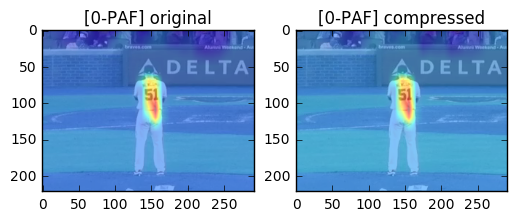

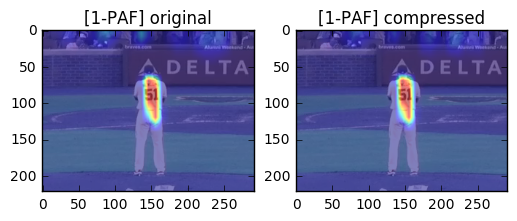

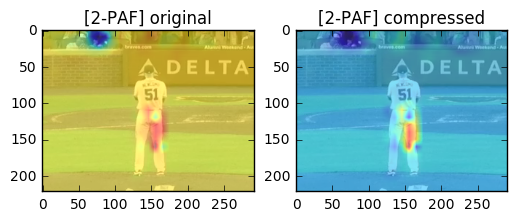

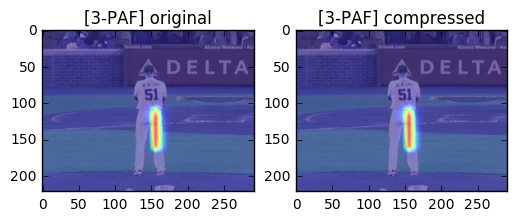

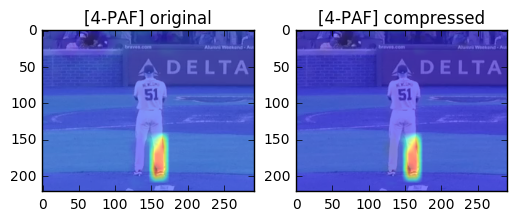

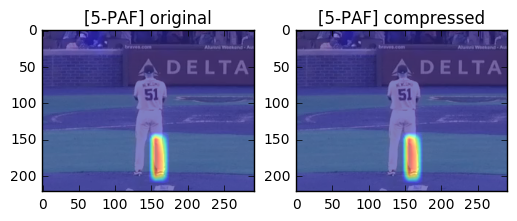

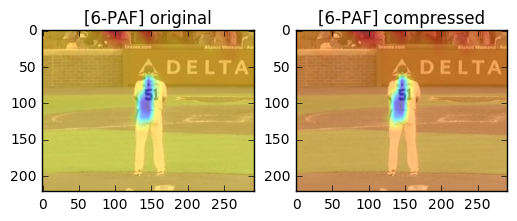

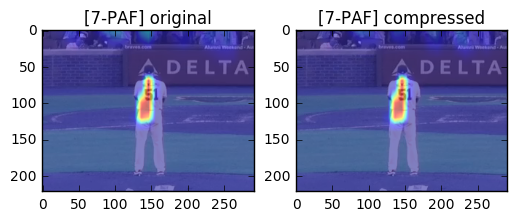

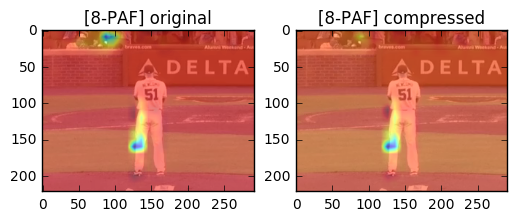

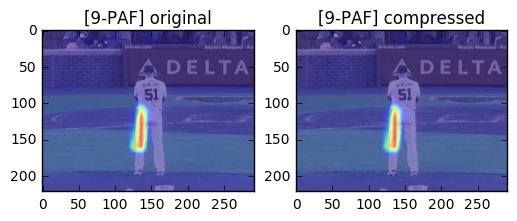

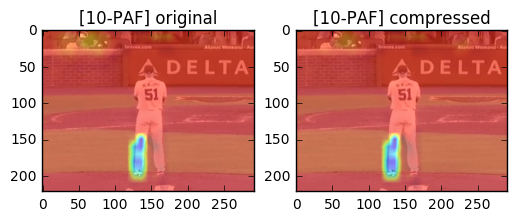

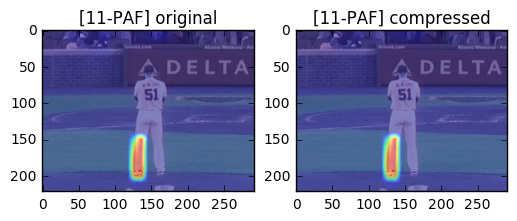

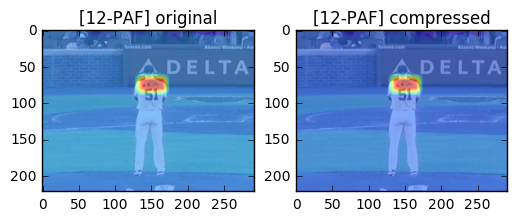

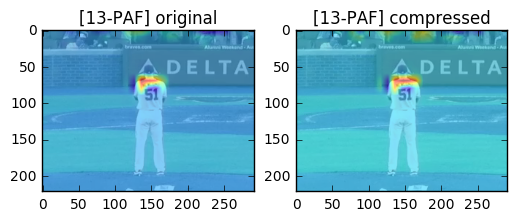

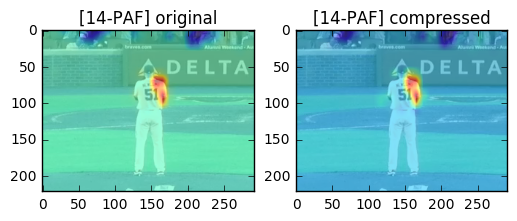

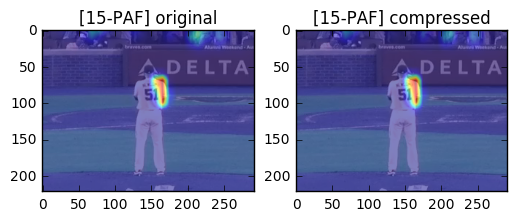

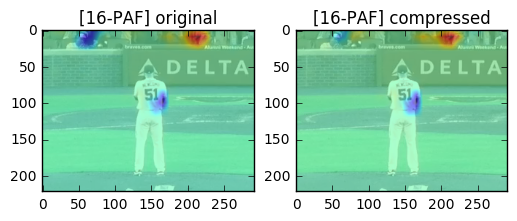

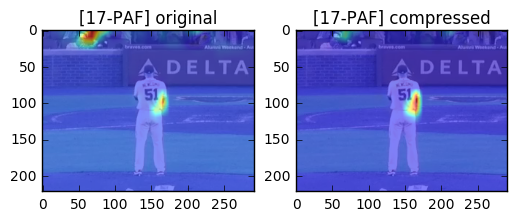

In [340]:
# show_comparison([res, comp_res], prefix='Heatmap', index=0)

for ii in range(18):
    show_comparison([res, comp_res], prefix='PAF', index=1, joint=ii)

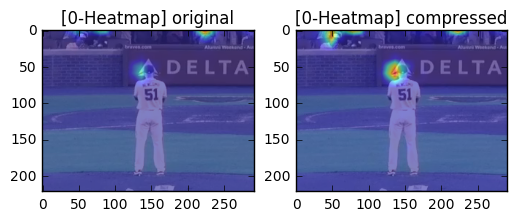

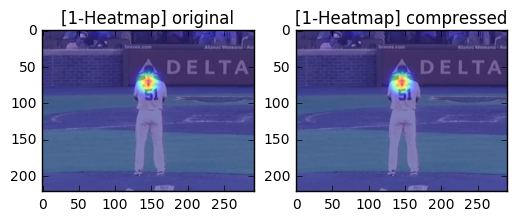

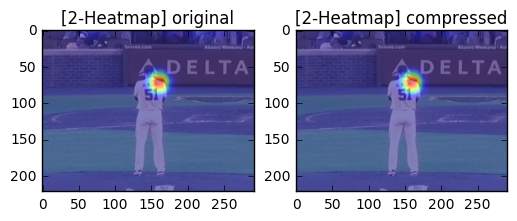

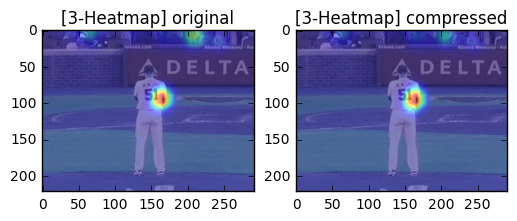

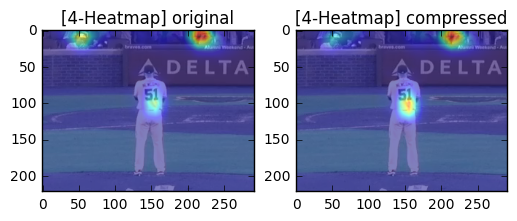

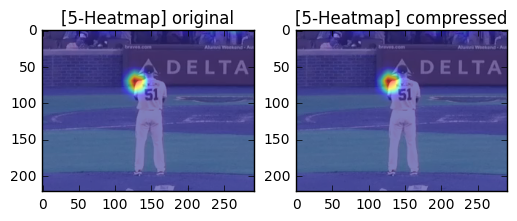

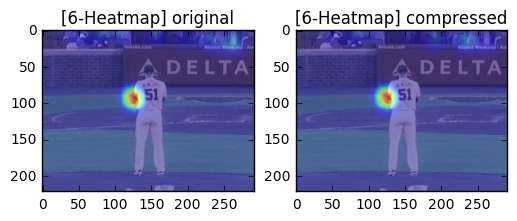

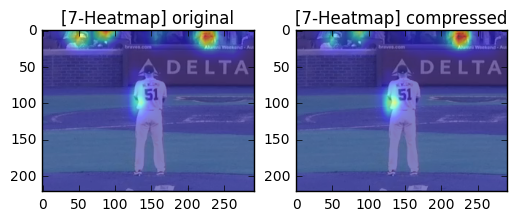

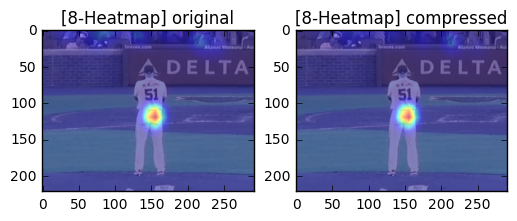

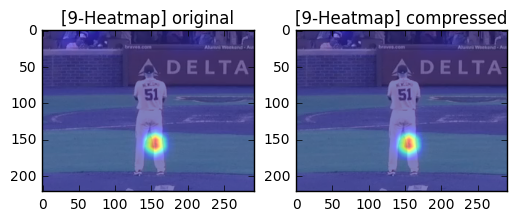

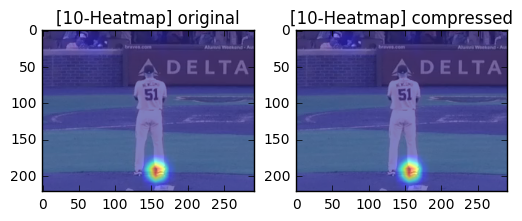

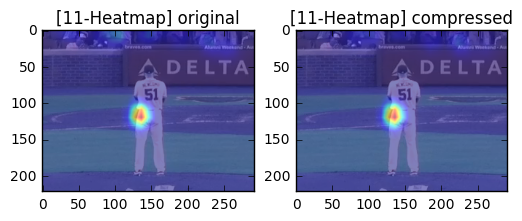

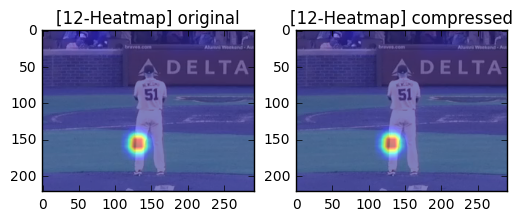

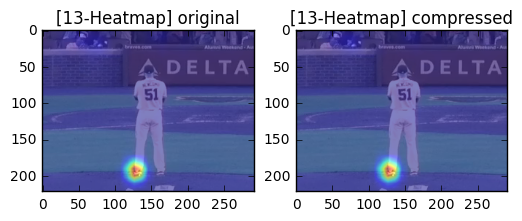

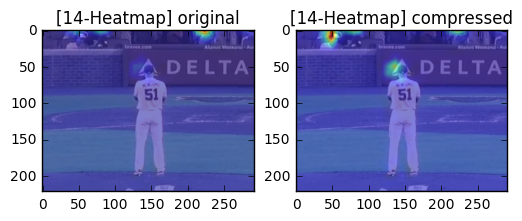

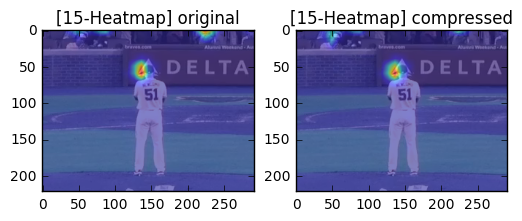

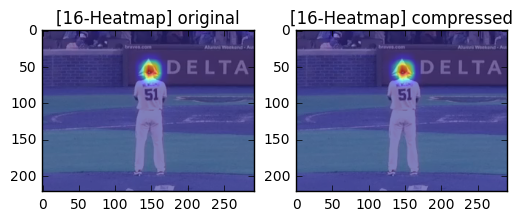

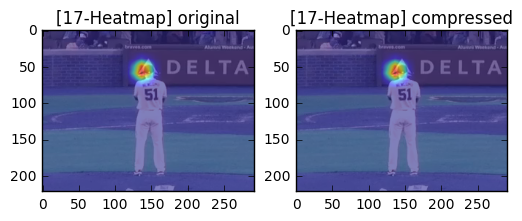

In [342]:
# show_comparison([res, comp_res], prefix='Heatmap', index=0)

for ii in range(18):
    show_comparison([res, comp_res], prefix='Heatmap', index=0, joint=ii)

In [343]:
# mod_model.save('../Pose_Estimation/model/keras/cmp_model_1.h5')
mod_model.save_weights('../Pose_Estimation/model/keras/cmp_model_1_w.h5')
mod_model.save('../Pose_Estimation/model/keras/cmp_model_1.h5')

In [321]:
from keras.models import load_model
lmodel = load_model('../Pose_Estimation/model/keras/cmp_model_1.h5')
lmodel.load_weights('../Pose_Estimation/model/keras/cmp_model_1_w.h5')

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
scale 0.828828828829
scale 0.828828828829
scale 0.828828828829
| AVG: 0.89
| MIN: 0.14
| MAX: 2.39
| TOT: 2.79


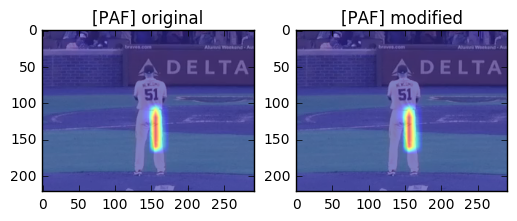

In [322]:
pframes = 3
l_res = process_video(lmodel, eval_model, limit_frames=pframes)

show_comparison([res, l_res], prefix='PAF', index=1)

In [324]:
lmodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, None, None, 64 1792                                         
____________________________________________________________________________________________________
activation_2241 (Activation)     (None, None, None, 64 0                                            
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, None, None, 64 36928                                        
___________________________________________________________________________________________

In [325]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, None, None, 64 1792                                         
____________________________________________________________________________________________________
activation_2401 (Activation)     (None, None, None, 64 0                                            
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, None, None, 64 36928                                        
___________________________________________________________________________________________